In [10]:
import random
import pandas as pd
from collections import defaultdict
import numpy as np
import json
import gzip
import json
import os
import heapq
import seaborn as sns
import matplotlib.pyplot as plt

In [11]:
df_gender = []
with gzip.open("C:/Users/Camille's PC/Documents/UCLEADS2019/authorBias/data/librarything_author_gender.json.gz") as fin:
    for l in fin:
        #print(l)
        d = json.loads(l)
        if d['author_gender'] != 'n/a':
            df_gender.append([d['author_name'], d['author_gender']])
df_gender = pd.DataFrame(df_gender, columns=['name', 'gender']).drop_duplicates()
df_gender.head()

,name,gender
0,Arthur Millier,male
1,Helen Little,female
2,Michael Moskowitz,male
3,Katherine Schober,female
4,Yingcong Dai,female


In [18]:
df_author = []
with gzip.open(os.path.join("C:/Users/Camille's PC/Documents/UCLEADS2019/authorBias/data/", 'goodreads_books_matched_poetry.json.gz')) as fin:
    for l in fin:
        
        d = json.loads(l)
        df_author.append([d['book_id'],d['title'],[i['author_id'] for i in d['authors']], [j['gender'] for j in d['authors']]])
df_author = pd.DataFrame(df_author, columns=['book_id','title','author_id', 'author_gender'])
single_authors_only = df_author[df_author['author_id'].str.len() ==1]
single_authors_only['author_id'] = single_authors_only['author_id'].map(lambda x: x[0])
single_authors_only['author_gender'] = single_authors_only['author_gender'].map(lambda x: x[0])
single_authors_only.drop( single_authors_only['author_gender']  == 'None', inplace=True)
single_authors_only.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/st

,book_id,title,author_id,author_gender
3,15861988,Into Temptation,2988946,female
4,9495428,Dark Sons,25492,female
5,554372,Geografías,30195,male
6,20544060,Black Liquor: Poems,547708,male
8,2067880,Cornflakes: Poems,68669,male


In [31]:
poetry_reviews = []
with gzip.open(os.path.join("C:/Users/Camille's PC/Documents/UCLEADS2019/authorBias/data/", 'goodreads_reviews_matched_poetry_en.json.gz')) as fin:
    for l in fin:
        d = json.loads(l)
        user = d['user_id']
        book = d['book_id']
        poetry_reviews.append([user,book, d['review_id'], d['rating']])
poetry_reviews = pd.DataFrame(poetry_reviews, columns=['user_id','book_id','review_id', 'rating'])
gb = poetry_reviews.groupby("user_id").filter(lambda x: len(x) >= 5)
user_author = gb.merge(single_authors_only, on='book_id', how='left').dropna()

In [32]:
len(user_author)

26913

In [33]:
training_data = {}
for index, row in user_author.iterrows():
     # access data using column names
    training_data[(row['user_id'], row['book_id'])] = row['rating']

In [34]:
user_to_book = {}
book_to_user = {}
book_to_title = {}
for index, row in user_author.iterrows():
    user, book, title =row['user_id'], row['book_id'], row['title']
    if user in user_to_book.keys():
        user_to_book[user].add(book)
    else:
        user_to_book[user] = set()
        user_to_book[user].add(book)
            
    if book in book_to_user.keys():
        book_to_user[book].add(user)
    else:
        book_to_user[book] = set()
        book_to_user[book].add(user)
        
    if book in book_to_title.keys():
        book_to_title[book].add(title)
    else:
        book_to_title[book] = set()
        book_to_title[book].add(title)

In [35]:
all_users = list(user_to_book.keys())
all_items = list(book_to_user.keys())

In [ ]:
#latent factor model
#perform grad descent
n=5
P= np.random.rand(len(all_users),n)
Q= np.random.rand(n, len(all_items))
alpha = 3
beta_u = np.random.rand(len(all_users),1)
beta_i = np.random.rand(len(all_items), 1)
index=0
lmbda = .05 #lambda hyperparam
gamma= .01 #gamma hyperparam
iterations = 25000
#try batch grad descent,or  try increasing learning rate and adding regularization terms
test_pair = random.choice(list(training_data.keys()))
(t_userId,t_itemId) = test_pair 
t_u = all_users.index(t_userId)    
t_i = all_items.index(t_itemId)

print("begin gradient descent")
for i in range(iterations):
    if i %5000==0:
        print("iteration number " + str(i) )
       # gamma = gamma*.1

    pair = random.choice(list(training_data.keys()))
    r_ui = training_data[pair]
    (userId,itemId) = pair    
    uIndex = all_users.index(userId)    
    iIndex = all_items.index(itemId)
    summation = 0
    #print((Q[:,iIndex]).shape)
    q_val = np.zeros((Q[:,iIndex]).shape) #innefiicient to make 2 different 2 matricies each loop, more effiecent to 
    p_val = np.zeros((P[uIndex,:]).shape)
    
    for j in range(n):
        summation += np.dot(P[uIndex][j],Q[j][iIndex])
        q_val += Q[j][iIndex]
        p_val += P[uIndex][j]
    grad_a = -2*(r_ui -(alpha + beta_u[uIndex] +beta_i[iIndex] + summation)) 
    grad_bu = 2*(r_ui -(alpha + beta_u[uIndex]+beta_i[iIndex] + summation))*-1
    grad_bi = 2*(r_ui -(alpha + beta_u[uIndex]+beta_i[iIndex] + summation))*-1
    grad_p = 2*(r_ui -(alpha + beta_u[uIndex]+beta_i[iIndex] + summation))*-q_val.T + lmbda*2*p_val
    grad_q =  2*(r_ui -(alpha + beta_u[uIndex]+beta_i[iIndex] + summation))*-p_val.T + lmbda*2*q_val

    
    alpha = alpha - gamma*grad_a
    beta_u[uIndex] = beta_u[uIndex] - gamma*grad_bu #change to only update relevent element of beta vector
    beta_i[iIndex] = beta_i[iIndex] - gamma*grad_bi
    P[uIndex,:] = P[uIndex,:] - gamma*grad_p
    Q[:,iIndex] = Q[:,iIndex] - gamma*grad_q
    if i ==iterations -1 :
        print("Current MSE: ")
        training_mse = 0
        for pair in training_data.keys():
            real_rating = training_data[pair]
            (userId,itemId) = pair
            userindex = all_users.index(userId)
            itemindex = all_items.index(itemId)
            pred_rating = alpha[0] + beta_u[userindex][0] +beta_i[itemindex][0] + np.dot(P[userindex],(Q.T)[itemindex]) + lmbda*(np.dot(P[userindex],P[userindex])+np.dot((Q.T)[itemindex],(Q.T)[itemindex])) 
            training_mse += (real_rating- pred_rating)**2
        print(str(training_mse/len(training_data.keys())))
    

begin gradient descent
iteration number 0
iteration number 5000
iteration number 10000


In [43]:
training_mse = 0
for pair in training_data.keys():
    real_rating = training_data[pair]
    (userId,itemId) = pair
    userindex = all_users.index(userId)
    itemindex = all_items.index(itemId)
    pred_rating = alpha[0] + beta_u[userindex][0] +beta_i[itemindex][0] + np.dot(P[userindex],(Q.T)[itemindex]) + lmbda*(np.dot(P[userindex],P[userindex])+np.dot((Q.T)[itemindex],(Q.T)[itemindex])) 
    training_mse += (real_rating- pred_rating)**2
print(str(training_mse/len(training_data.keys())))

1.1365782188966467


lmbda = .005 lambda hyperparam
gamma= .01 gamma hyperparam
iterations = 25000
1.1365782188966467

lmbda = .01 #lambda hyperparam
gamma= .01 #gamma hyperparam
iterations = 25000
1.1243317662190484

lmbda = .05 #lambda hyperparam
gamma= .01 #gamma hyperparam
iterations = 25000
1.1656186143471832

# Produce Recommendations with LFM
1) Get list of users and the set of all books
2) For each user in the list: 
    a) remove the books this user has purchased from set
    b) find index of highest predicted rating books
    c) return 50 highest rated books


In [46]:
main = user_author.groupby("user_id").filter(lambda x: len(x) >= 5)
srs = main.drop_duplicates('user_id')['user_id'].sample(n=1000,random_state=24 )
srs.count()

1000

In [51]:
#rating produced by r_ui = P[u]*Q[i]
users = srs.tolist() #list of all the users in the sample
#all_items - list of all books
#userindex = all_users.index(userId) - get index from id for user 
#itemindex = all_items.index(itemId) - get index from id for book
user_to_recs = {}
num_recs = 50
for u in users:
    possible_recs = set(book_to_user.keys())
    purchased_books = user_to_book[u]
    current_user_index = all_users.index(u)
    this_user_recs = {}
    for book in possible_recs:
        if book not in purchased_books:
            book_index = all_items.index(book)
            pred_rating = alpha[0] + beta_u[current_user_index] +beta_i[book_index][0] + np.dot(P[current_user_index],(Q.T)[book_index]) + lmbda*(np.dot(P[current_user_index],P[current_user_index])+np.dot((Q.T)[book_index],(Q.T)[book_index])) 
            this_user_recs[book] = pred_rating
    user_to_recs[u] = heapq.nlargest(num_recs, this_user_recs.keys())
    

In [63]:
beta_i[book_index][0]

0.16021583717629295

In [52]:
rec_ratio = {}
proportions = []
running_total_females = 0
running_overall_total = 0
users= set(user_to_recs.keys())


for u in users:
    recs = user_to_recs[u]
    #print(recs)
    total_reviews = len(recs)
    num_females = len(single_authors_only[(single_authors_only['book_id'].isin(recs)) & (single_authors_only['author_gender'] =='female')]['book_id'].unique())
    
    ratio = num_females/total_reviews
    running_total_females += num_females
    running_overall_total += total_reviews
    rec_ratio[u] = ratio
    proportions.append(ratio)
print("overall proportion: ", str(running_total_females/running_overall_total))

overall proportion:  0.35946


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


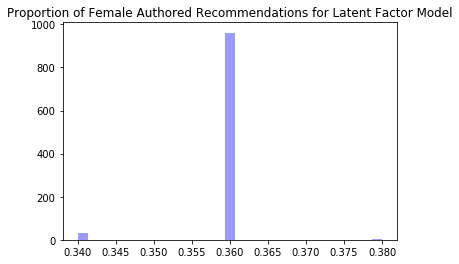

In [59]:
sns_plot = sns.distplot(proportions, kde=False, color='b', rug=False).set_title("Proportion of Female Authored Recommendations for Latent Factor Model")
fig = sns_plot.get_figure()
fig.savefig("LFM_rec_proportion_noKDE.png")
plt.show()

In [58]:
i = pd.DataFrame(data = {'proportion': proportions}) 
i.describe()

,proportion
count,1000.000000
mean,0.359460
std,0.003915
min,0.340000
25%,0.360000
50%,0.360000
75%,0.360000
max,0.380000
